In [1]:
import sys
sys.path.append('../')
import potential as potlib
from gala.units import UnitSystem
from astropy import units as u
usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
import jax.numpy as jnp

import diffrax
import fields as fields

import StreamSculptor
import potential
import matplotlib.pyplot as plt
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)


In [2]:
from jax.scipy import special
special.gammainc(1, 1)

Array(0.63212056, dtype=float64, weak_type=True)

Initial condition = [ -7.23094471  -7.96765546 -10.81846758   0.19183242  -0.20350666
  -0.01769461]


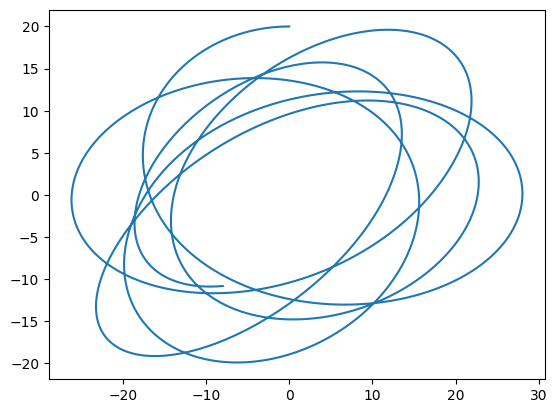

In [2]:
## Define a potential
pot_MW = potential.GalaMilkyWayPotential(units=usys)

## Define a stream progenitor (observed today)
w_today = jnp.array([20.0,0.0,20,.0,.15,.0]) # position units: kpc, velocity units: kpc/Myr

## Stream age
t_age = 3_500 # Myr

## Times to backwards integrate through
ts_back = jnp.linspace(0,-t_age, 1000) #save 1000 points
init_cond = pot_MW.integrate_orbit(w0=w_today, ts=ts_back,t0=0.0, t1=-t_age)

## Initial condition at t1 = -t_age
IC = init_cond.ys[-1]
print('Initial condition = ' + str(IC))
plt.plot(init_cond.ys[:,1], init_cond.ys[:,2]);

In [4]:
## Now define stream model.
## First need stripping times. 
## Last element of the stripping time array is the observation time, that all
## particles will be integrated to.
t_strip = jnp.linspace(-t_age,0, 5000)
Mcluster0 = 1e4 # Msun

## Streamsculptor works with gpu, for which jax.vmap is more effecient than jax.lax.scan.
## IF using cpu, use jax.lax.scan instead.
#lead,trail = pot_MW.gen_stream_vmapped(ts=t_strip, prog_w0=IC, Msat=Mcluster, seed_num=583,)

## Same function, but better for cpu usage. This produces the same result as the above.

Mcluster = jnp.linspace(Mcluster0,0.0,len(t_strip))
lead,trail = pot_MW.gen_stream_scan(ts=t_strip, prog_w0=IC, Msat=Mcluster, seed_num=583)


In [5]:
stream = jnp.vstack([lead,trail])


In [6]:
stream = np.asarray(stream)

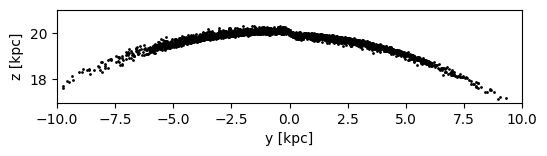

In [7]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)
ax.scatter(stream[:,1], stream[:,2], s=1,rasterized=True,color='k')
ax.set_xlabel('y [kpc]')
ax.set_ylabel('z [kpc]')
ax.set_xlim(-10,10)
ax.set_ylim(17,21)
ax.set_aspect('equal')


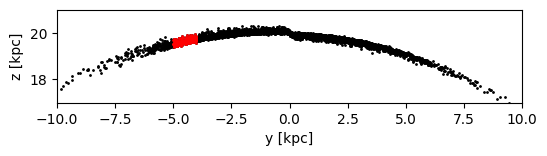

In [7]:
## Select a subset of the stream particles
y_in_bool = (stream[:,1] > -5) & (stream[:,1] < -4) 

fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)
ax.scatter(stream[:,1], stream[:,2], s=1,rasterized=True,color='k')
ax.scatter(stream[y_in_bool,1], stream[y_in_bool,2], s=1,rasterized=True,color='r')

ax.set_xlabel('y [kpc]')
ax.set_ylabel('z [kpc]')
ax.set_xlim(-10,10)
ax.set_ylim(17,21)
ax.set_aspect('equal')


In [10]:
## Take the average phasespace location of the selected region. 
avg_wtoday = stream[y_in_bool,:].mean(axis=0)
## Integrate this back to an impact time, at which a subhalo will intersect with the red patch
t_impact = -1000.0 # Myr
w_impact = pot_MW.integrate_orbit(w0=avg_wtoday, ts=jnp.array([0,t_impact]),t0=0.0, t1=t_impact).ys[-1]
print('Impact location = ' + str(w_impact))

## Give the subhalo a slightly different veloction compared to the stream
w_subalo = w_impact + jnp.array([0,0,0,.02,0.0,.02])
M_sh = jnp.array([1e7]) # Msun
r_sh = jnp.array([0.2]) # kpc

## Define the subhalo potential. We will use the SubhaloLinePotential: implements a plummer sphere subhalo 
## potential moving on a straight line.
## t_winodw is the window in time for which the subhalo potential is active.
## outside of subhalo_t0 +- t_window, the subhalo potential is zero.
## All parameters are defined using array inputs, so that multiple subhalos can be defined at once. 
pot_SH = potential.SubhaloLinePotential(m=M_sh,a=r_sh,subhalo_x0=jnp.array([w_subalo[:3]]), 
                                            subhalo_v=jnp.array([w_subalo[3:]]),
                                            subhalo_t0=jnp.array([t_impact]), t_window=jnp.array([250.0]),units=usys)

## Combine subhalo potential and MW potential
pot_list = [pot_MW,pot_SH]
pot_total = potential.Potential_Combine(potential_list=pot_list, units=usys)



Impact location = [-18.84432695   4.24072382 -17.32783861  -0.0441807   -0.15074143
  -0.07958244]


In [11]:
Mcluster.shape, t_strip.shape

((5000,), (5000,))

In [13]:
## Generate stream with subhalo
## You _can_ use pot.gen_stream_vmapped or scan, but you run the risk of nans
## due to computation of the tidal tensor at the progenitor's location
## also accounting for a massive subhalo flyby. The function below
## calculates the tidal field of the MW potential at the progenitor's location in determining the
## tidal radis of the progenitor. This is a safer choice for generating streams with subhalos.
lead_pert , trail_pert = StreamSculptor.gen_stream_scan_with_pert(pot_base=pot_MW,pot_pert=pot_SH,ts=t_strip, prog_w0=IC, Msat=Mcluster, seed_num=583,)


In [14]:
stream_pert = jnp.vstack([lead_pert,trail_pert])

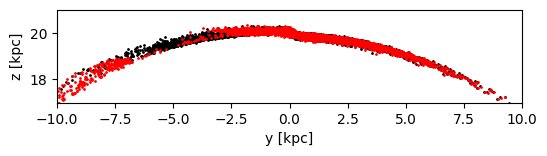

In [15]:
## plot the result
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)
ax.scatter(stream[:,1], stream[:,2], s=1,rasterized=True,color='k')
ax.scatter(stream_pert[:,1], stream_pert[:,2], s=1,rasterized=True,color='r')

ax.set_xlabel('y [kpc]')
ax.set_ylabel('z [kpc]')
ax.set_xlim(-10,10)
ax.set_ylim(17,21)
ax.set_aspect('equal')
